In [1]:
%matplotlib inline
#导入相关依赖库
from matplotlib import pyplot
import numpy as np
import mindspore as ms
import mindspore.context as context
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.nn.metrics import Accuracy
from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import  LossMonitor, CheckpointConfig, ModelCheckpoint
context.set_context(mode=context.GRAPH_MODE, device_target='CPU') 
from mindspore.train.callback import ModelCheckpoint,CheckpointConfig
from mindspore import load_checkpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
DATA_DIR_TRAIN = "D:/DL/MNIST/MNIST/train" # 训练集信息
DATA_DIR_TEST = "D:/DL/MNIST/MNIST/test" # 测试集信息

In [3]:
def create_dataset(training=True, batch_size=128, resize=(28, 28),rescale=1/255, shift=-0.5, buffer_size=64):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    
    #定义改变形状、归一化和更改图片维度的操作。
    #改为（28,28）的形状
    resize_op = CV.Resize(resize)
    #rescale方法可以对数据集进行归一化和标准化操作，这里就是将像素值归一到0和1之间，shift参数可以让值域偏移至-0.5和0.5之间
    rescale_op = CV.Rescale(rescale, shift)
    #由高度、宽度、深度改为深度、高度、宽度
    hwc2chw_op = CV.HWC2CHW()
    
    # 利用map操作对原数据集进行调整
    ds = ds.map(input_columns="image", operations=[resize_op, rescale_op, hwc2chw_op])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    #设定洗牌缓冲区的大小，从一定程度上控制打乱操作的混乱程度
    ds = ds.shuffle(buffer_size=buffer_size)
    #设定数据集的batch_size大小，并丢弃剩余的样本
    ds = ds.batch(batch_size, drop_remainder=True)
    
    return ds

In [4]:
#生成训练集
ds_train = create_dataset(True, batch_size=32)
#生成验证集，验证机不需要训练，所以不需要repeat
ds_eval = create_dataset(False, batch_size=32)

In [5]:
class ForwardNN(nn.Cell):      
    def __init__(self):
        super(ForwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Dense(784, 256, activation='relu')
        self.fc2 = nn.Dense(256, 10, activation='softmax')
    
    def construct(self, input_x):
        output = self.flatten(input_x)
        output = self.fc1(output)
        output = self.fc2(output)
        return output 

In [6]:
lr = 0.001
num_epoch = 10

net = ForwardNN()
loss = nn.loss.SoftmaxCrossEntropyWithLogits( sparse=True, reduction='mean')
metrics={"Accuracy": Accuracy()}
#定义优化器为Adam优化器，并设定学习率
opt = nn.Adam(net.trainable_params(), lr)

In [8]:
model = Model(net, loss, opt, metrics)
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpt_cb = ModelCheckpoint(prefix='ForwardNN', directory='D:/DL/MNIST/Mindspore/model',config=config_ck)

In [10]:
print("============== Starting Training ==============")
model.train(num_epoch, ds_train,callbacks=[LossMonitor(1875), ckpt_cb],dataset_sink_mode=False)

============== Starting Training ==============
epoch: 1 step: 1875, loss is 1.515730619430542
epoch: 2 step: 1875, loss is 1.5149266719818115
epoch: 3 step: 1875, loss is 1.5279228687286377
epoch: 4 step: 1875, loss is 1.5218631029129028
epoch: 5 step: 1875, loss is 1.4611765146255493
epoch: 6 step: 1875, loss is 1.4611563682556152
epoch: 7 step: 1875, loss is 1.5059442520141602
epoch: 8 step: 1875, loss is 1.519830346107483
epoch: 9 step: 1875, loss is 1.4922549724578857
epoch: 10 step: 1875, loss is 1.506061315536499


In [11]:
#使用测试集评估模型，打印总体准确率
metrics_result=model.eval(ds_eval)
print(metrics_result)

[WARNING] ME(18912:3540,MainProcess):2022-03-22-15:33:38.365.447 [mindspore\train\model.py:968] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


{'Accuracy': 0.9665464743589743}


In [7]:
net_test = ForwardNN()
load_checkpoint('D:/DL/MNIST/Mindspore/model/ForwardNN-5_1875.ckpt',net = net_test)
Copymetrics = {
    'accuracy': nn.Accuracy(),
    'loss': nn.Loss(),
    'precision': nn.Precision(),
    'recall': nn.Recall(),
    'f1_score': nn.F1()
}
model_test = Model(net_test, loss,metrics=Copymetrics)
acc = model_test.eval(ds_eval)
acc

[WARNING] ME(5840:1992,MainProcess):2022-03-28-21:14:47.654.505 [mindspore\common\parameter.py:338] The parameter definition is deprecated.
Please set a unique name for the parameter 'Parameter (name=Parameter, shape=(256, 784), dtype=Float32, requires_grad=True)'.
[WARNING] ME(5840:1992,MainProcess):2022-03-28-21:14:47.654.505 [mindspore\common\parameter.py:338] The parameter definition is deprecated.
Please set a unique name for the parameter 'Parameter (name=Parameter, shape=(256,), dtype=Float32, requires_grad=True)'.
[WARNING] ME(5840:1992,MainProcess):2022-03-28-21:14:47.655.502 [mindspore\common\parameter.py:338] The parameter definition is deprecated.
Please set a unique name for the parameter 'Parameter (name=Parameter, shape=(10, 256), dtype=Float32, requires_grad=True)'.
[WARNING] ME(5840:1992,MainProcess):2022-03-28-21:14:47.656.499 [mindspore\common\parameter.py:338] The parameter definition is deprecated.
Please set a unique name for the parameter 'Parameter (name=Paramet

{'accuracy': 0.9632411858974359,
 'loss': 1.498733911376733,
 'precision': array([0.96031746, 0.98061674, 0.96868885, 0.96215139, 0.97789474,
        0.96598639, 0.96189495, 0.96930693, 0.95525494, 0.92987512]),
 'recall': array([0.98876404, 0.98148148, 0.96491228, 0.95643564, 0.94699286,
        0.95945946, 0.97698745, 0.95326193, 0.94250513, 0.95936571]),
 'f1_score': array([0.97433317, 0.98104892, 0.96679688, 0.959285  , 0.96219575,
        0.96271186, 0.96938246, 0.96121748, 0.94883721, 0.94439024])}

In [8]:
category_dict = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
cifar_ds = create_dataset(False, batch_size=1)
test_label = []
test_pred = []
for data in cifar_ds.create_dict_iterator(num_epochs=1, output_numpy=True):
    test_label.append(int(data['label']))
    input_img = ms.Tensor(data['image'])
    output = net_test(input_img)
    output = nn.Softmax(axis=1)(output)
    pred = output.asnumpy()
    pred = np.argmax(pred)
    test_pred.append(int(category_dict[pred]))

In [9]:
cm = confusion_matrix(test_label, test_pred)
cm

array([[ 969,    0,    0,    0,    1,    1,    4,    1,    3,    1],
       [   0, 1114,    5,    1,    0,    0,    3,    0,   12,    0],
       [   6,    2,  996,    5,    2,    3,    4,    8,    6,    0],
       [   0,    1,    8,  966,    1,    6,    1,   11,   10,    6],
       [   2,    0,    4,    0,  930,    0,    7,    1,    2,   36],
       [   3,    0,    0,    8,    2,  856,   12,    0,    5,    6],
       [   7,    4,    2,    0,    1,    4,  936,    1,    3,    0],
       [   3,    9,   12,    4,    2,    0,    0,  980,    0,   18],
       [  11,    1,    1,   11,    5,   11,    5,    5,  918,    6],
       [   8,    5,    0,    9,    7,    5,    1,    4,    2,  968]],
      dtype=int64)

<AxesSubplot:>

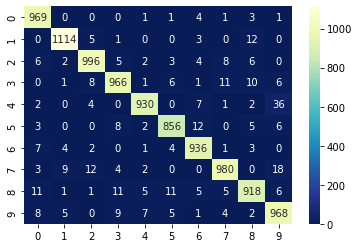

In [10]:
sns.heatmap(cm,cmap="YlGnBu_r",annot=True,fmt='d')